In [ ]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pprint import pprint
import os.path as pth

import gzip
import pickle

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Flatten, Reshape
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split, KFold, GroupKFold

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
ROOT_DIR = '../data'
TRAIN_IMG_DIR = pth.join(ROOT_DIR, 'original/train_images')
TRAIN_DATA_DIR = ROOT_DIR

WIDTH=1600
HEIGHT=256

In [ ]:
data = pd.read_feather(pth.join(TRAIN_DATA_DIR, 'train.feather'))

In [ ]:
image_groups = data.groupby('imageid')

s = image_groups[['mask_present']].sum().mask_present
s.name = 'nmasks'
data = data.merge(s, left_on=['imageid'], right_index=True)

In [ ]:
data.head()

In [ ]:
with gzip.open(pth.join(TRAIN_DATA_DIR, 'train_masks.pickle.gz'), 'rb') as f:
    image_masks = pickle.load(f)

from loaders import BlockwiseImageLoader
n = 4
b = BlockwiseImageLoader(train_cv_image_names[0:10], image_groups, image_masks, n, 128, 64)
img_patches, mask_patches = b[0]
imgs = b.combine_patches(img_patches)

for i in range(n):
    name = train_cv_image_names[i]
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(imgs[i], cmap='gray')
    plt.show()


In [210]:
from models import SimpleAE, SimpleInception

model = SimpleAE(64)
model.build_model()
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d_827 (Conv2D)             (None, 256, 1600, 16 160         input_54[0][0]                   
__________________________________________________________________________________________________
conv2d_828 (Conv2D)             (None, 256, 1600, 16 2320        conv2d_827[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_147 (MaxPooling2D (None, 64, 800, 16)  0           conv2d_828[0][0]                 
___________________________________________________________________________________________

In [211]:
image_names = list(data[data.nmasks > 0].imageid.unique())[0:1000]
train_cv_image_names, test_image_names = train_test_split(image_names)
len(train_cv_image_names), len(test_image_names)

(750, 250)

In [212]:
from loaders import ImageLoader, BlockwiseImageLoader

BATCH_SIZE = 4
PATCH_SIZE = 64
PATCH_STRIDE = 32

kfold = KFold(2)

for train_indices, cv_indices in kfold.split(train_cv_image_names):
    train_image_names = [train_cv_image_names[i] for i in train_indices]
    cv_image_names = [train_cv_image_names[i] for i in cv_indices]
    print(f'{len(train_image_names)} training samples, {len(cv_image_names)} validation samples')
    model.fit_generator(
        generator=ImageLoader(train_image_names, image_groups, image_masks, 
                              BATCH_SIZE),#, PATCH_SIZE, PATCH_STRIDE),
        validation_data=ImageLoader(cv_image_names, image_groups, image_masks, 
                                    BATCH_SIZE),#, PATCH_SIZE, PATCH_STRIDE),
        epochs=20)

375 training samples, 375 validation samples
Epoch 1/20
94/94 [==============================] - 37s 398ms/step - loss: 0.5140 - conv2d_839_loss: 0.0585 - conv2d_846_loss: 0.0401 - conv2d_853_loss: 0.2618 - conv2d_860_loss: 0.1536 - val_loss: 0.2662 - val_conv2d_839_loss: 0.0099 - val_conv2d_846_loss: 0.0112 - val_conv2d_853_loss: 0.1769 - val_conv2d_860_loss: 0.0683
Epoch 2/20
94/94 [==============================] - 23s 243ms/step - loss: 0.2729 - conv2d_839_loss: 0.0170 - conv2d_846_loss: 0.0024 - conv2d_853_loss: 0.1740 - conv2d_860_loss: 0.0796 - val_loss: 0.2925 - val_conv2d_839_loss: 0.0092 - val_conv2d_846_loss: 0.0065 - val_conv2d_853_loss: 0.1965 - val_conv2d_860_loss: 0.0803
Epoch 3/20
94/94 [==============================] - 23s 243ms/step - loss: 0.2572 - conv2d_839_loss: 0.0125 - conv2d_846_loss: 0.0025 - conv2d_853_loss: 0.1701 - conv2d_860_loss: 0.0720 - val_loss: 0.2575 - val_conv2d_839_loss: 0.0090 - val_conv2d_846_loss: 0.0122 - val_conv2d_853_loss: 0.1799 - val_conv

In [213]:
model.model.history.history.keys()

dict_keys(['loss', 'conv2d_839_loss', 'conv2d_846_loss', 'conv2d_853_loss', 'conv2d_860_loss', 'val_loss', 'val_conv2d_839_loss', 'val_conv2d_846_loss', 'val_conv2d_853_loss', 'val_conv2d_860_loss'])

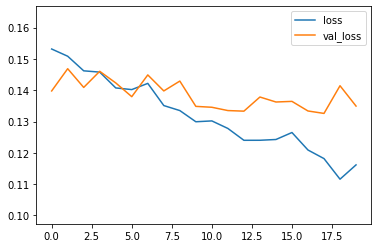

In [214]:
def plot_history(history, keys=['loss', 'val_loss']):
    if len(keys) == 0:
        return
    
    n = 3
    primary = np.array(history[keys[0]])
    ymin = primary.mean() - primary.std() * n
    ymax = primary.mean() + primary.std() * n
    
    plt.figure()
    plt.ylim(ymin, ymax)
    for key in keys:
        if key in history.keys():
            #plt.plot(np.arange(len(history[key])), history[key], label=key)
            plt.plot(history[key], label=key)
        else:
            print(f'Unable to plot {key}')
    plt.legend()
    plt.show()
    
plot_history(model.model.history.history)
    

In [215]:
names = test_image_names[0:10]
loader = ImageLoader(names, image_groups, image_masks,
                     BATCH_SIZE)#, PATCH_SIZE, PATCH_STRIDE)
results = model.predict_generator(generator=loader)
#results = loader.combine_mask_patches(results)

25fc987a1


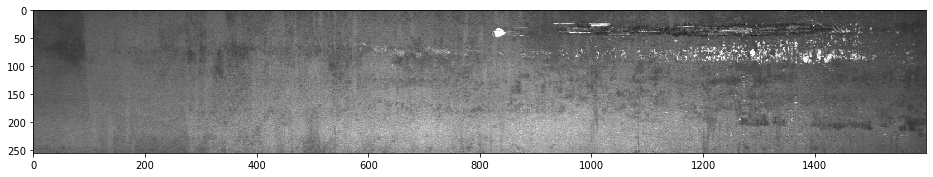

25fc987a1 1 REF


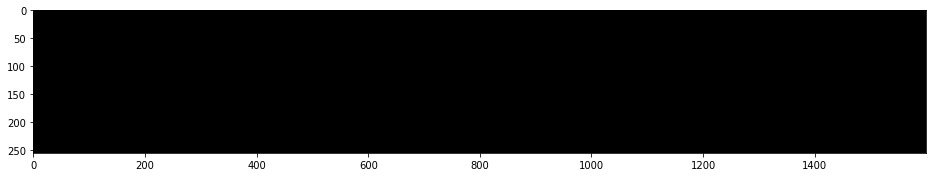

25fc987a1 1 TEST 336034


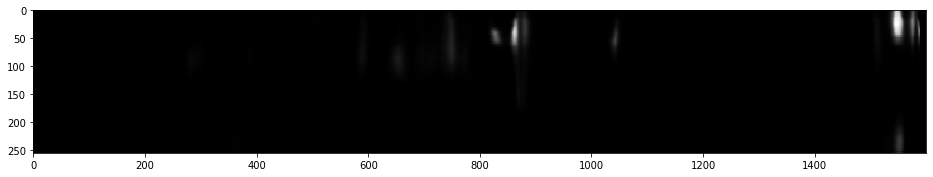

25fc987a1 2 REF


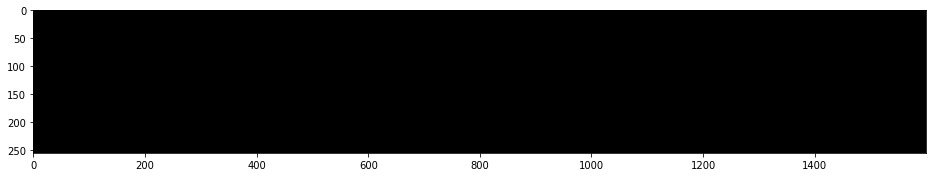

25fc987a1 2 TEST 113865


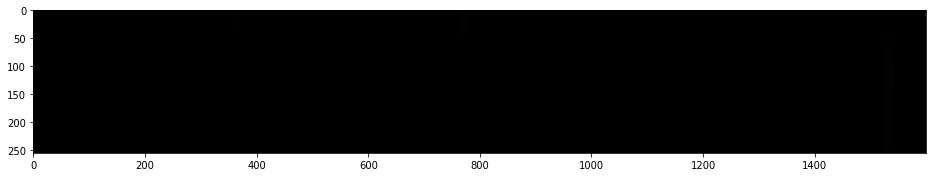

25fc987a1 3 REF


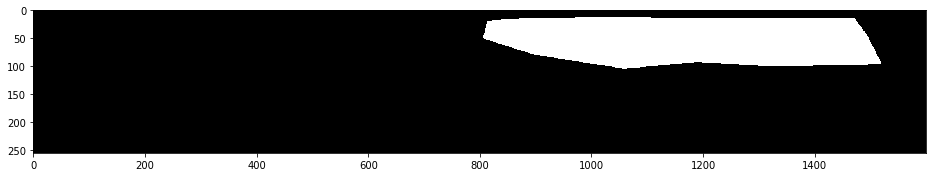

25fc987a1 3 TEST 409600


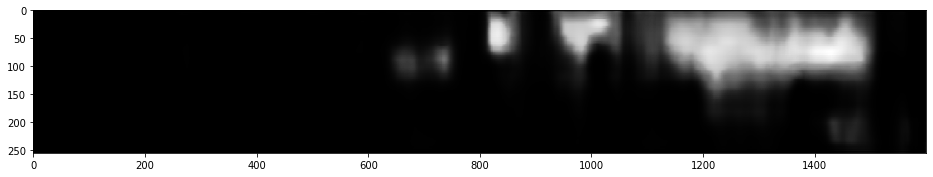

25fc987a1 4 REF


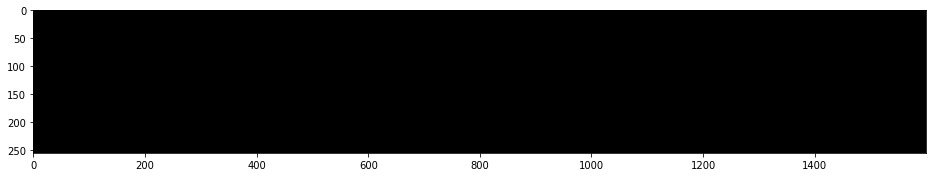

25fc987a1 4 TEST 409457


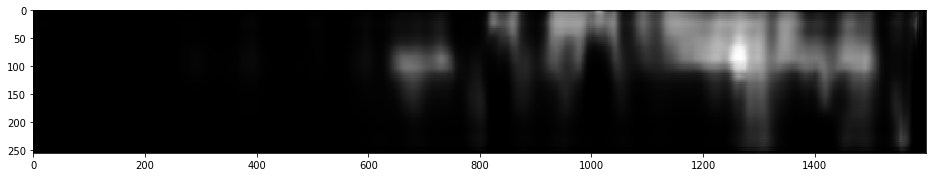

02701c239


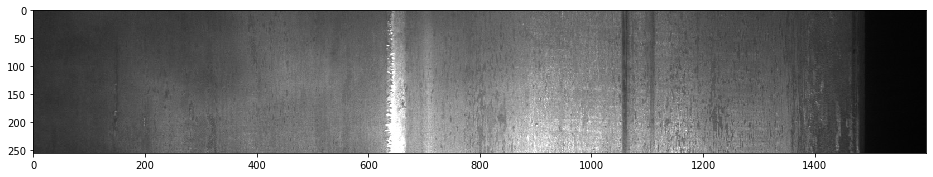

02701c239 1 REF


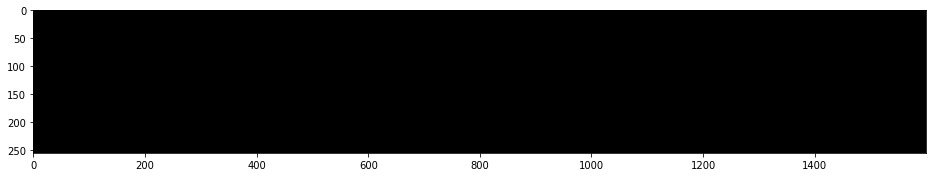

02701c239 1 TEST 378700


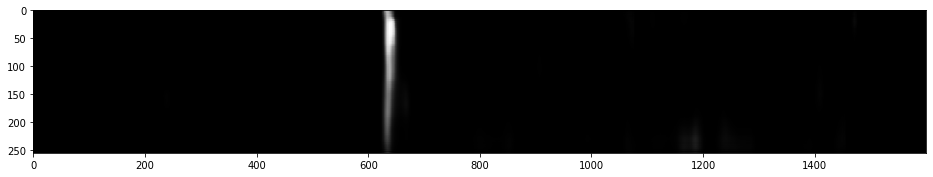

02701c239 2 REF


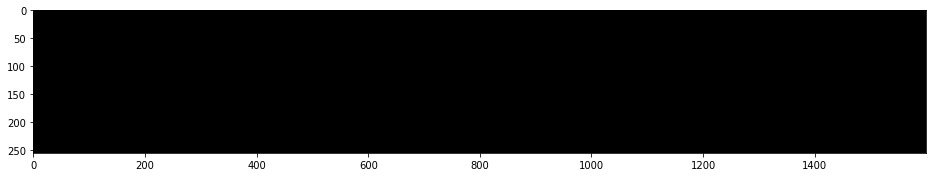

02701c239 2 TEST 263733


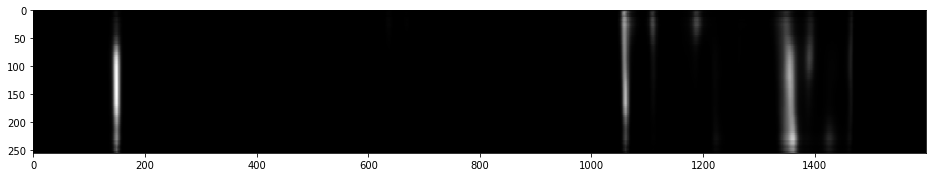

02701c239 3 REF


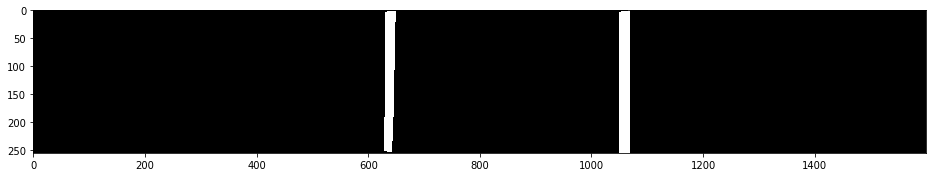

02701c239 3 TEST 388005


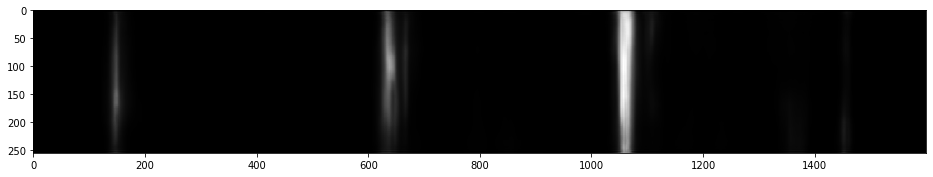

02701c239 4 REF


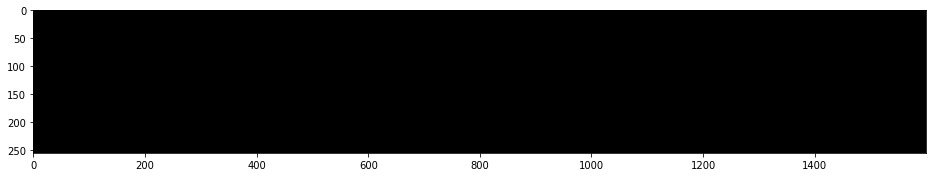

02701c239 4 TEST 372015


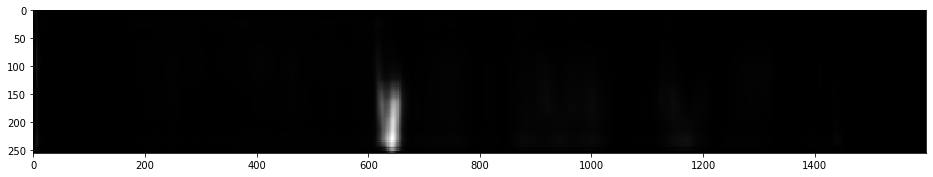

02d8c6b30


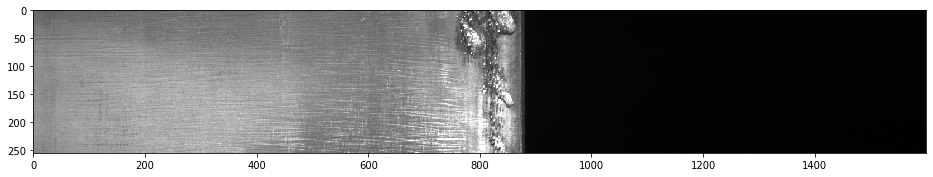

02d8c6b30 1 REF


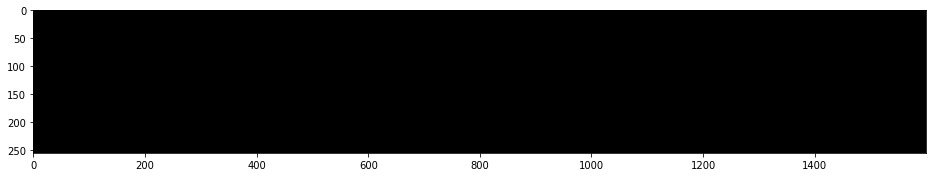

02d8c6b30 1 TEST 209010


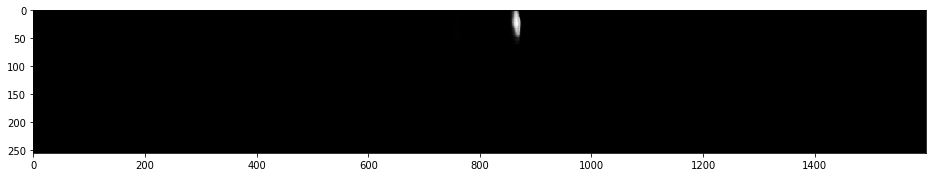

02d8c6b30 2 REF


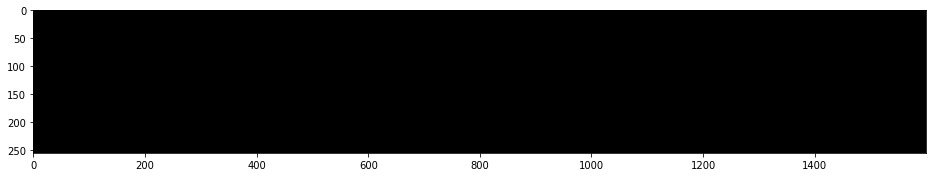

02d8c6b30 2 TEST 8028


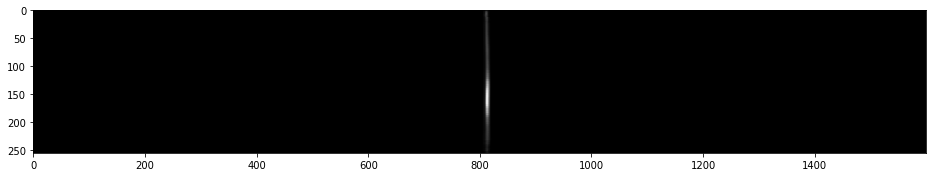

02d8c6b30 3 REF


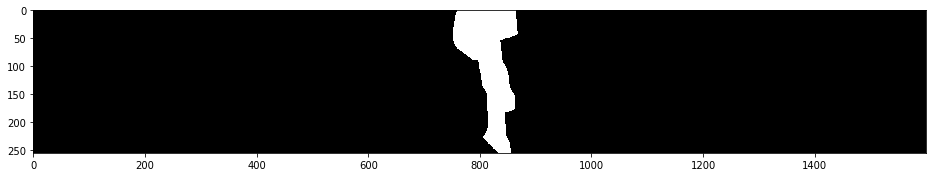

02d8c6b30 3 TEST 231798


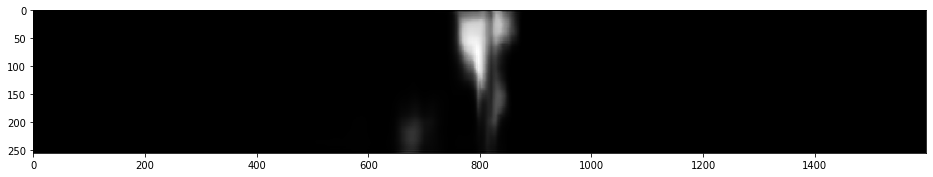

02d8c6b30 4 REF


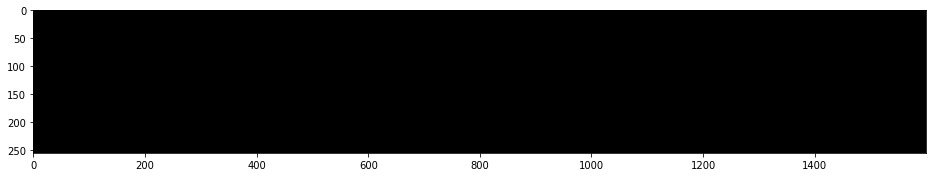

02d8c6b30 4 TEST 219651


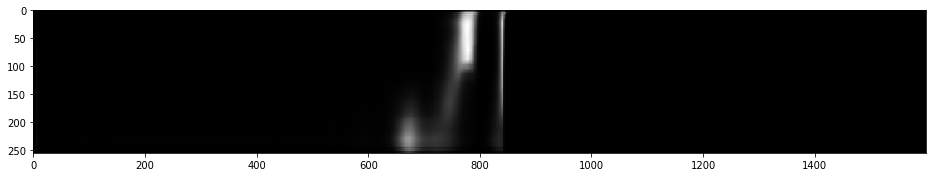

01b043500


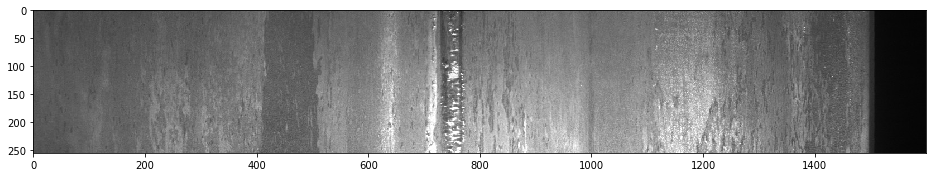

01b043500 1 REF


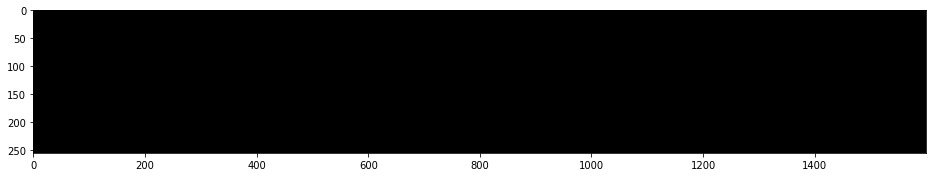

01b043500 1 TEST 381623


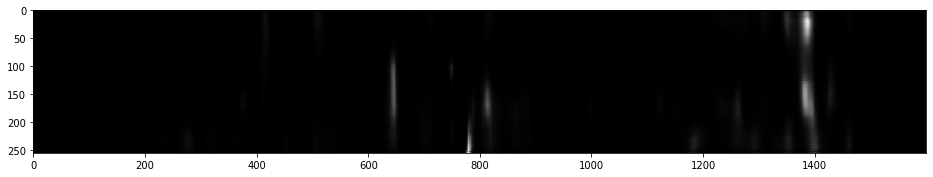

01b043500 2 REF


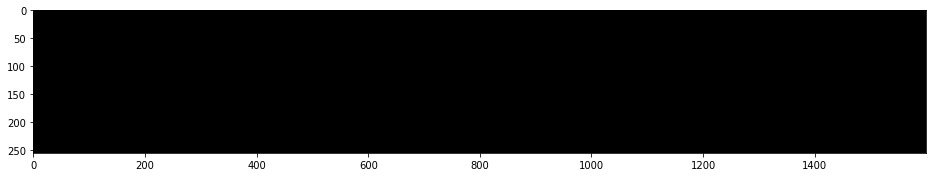

01b043500 2 TEST 262860


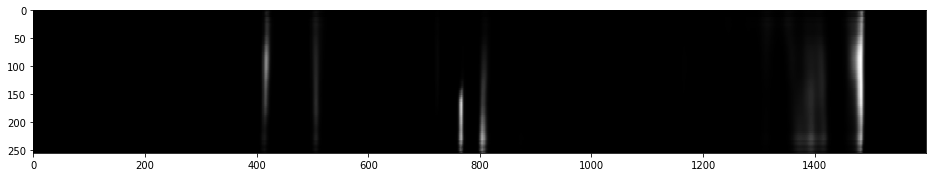

01b043500 3 REF


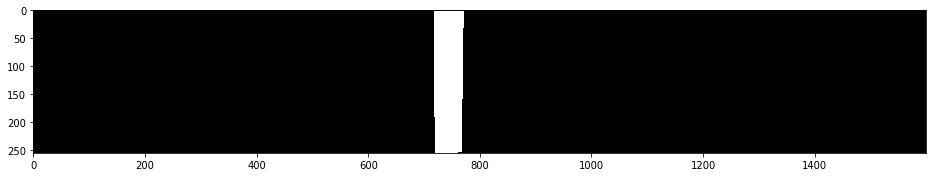

01b043500 3 TEST 393493


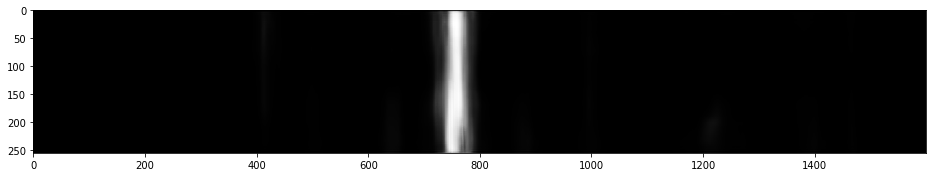

01b043500 4 REF


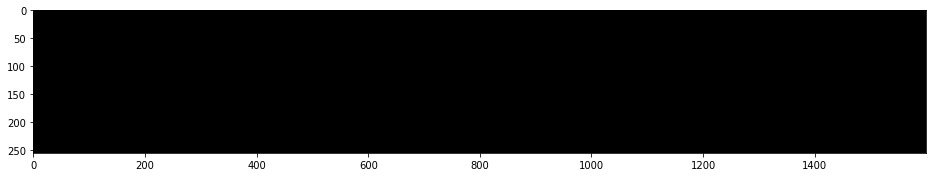

01b043500 4 TEST 375478


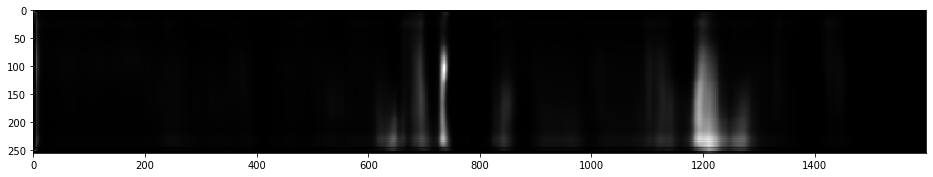

2188f5429


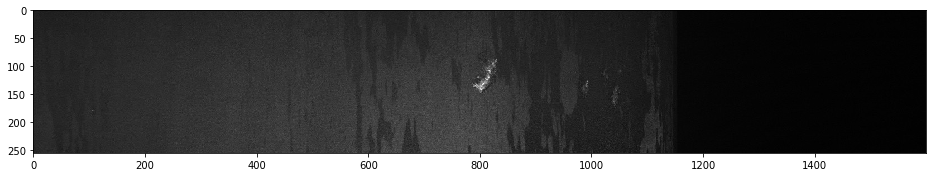

2188f5429 1 REF


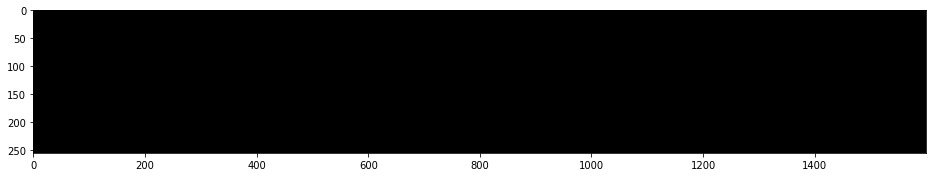

2188f5429 1 TEST 286024


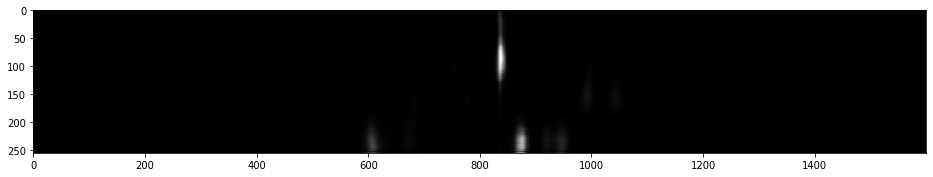

2188f5429 2 REF


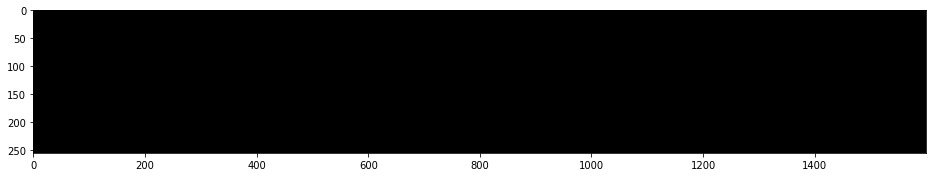

2188f5429 2 TEST 223326


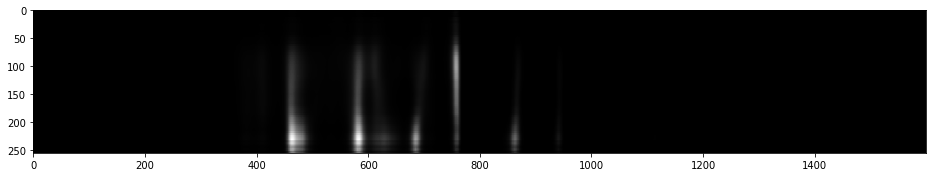

2188f5429 3 REF


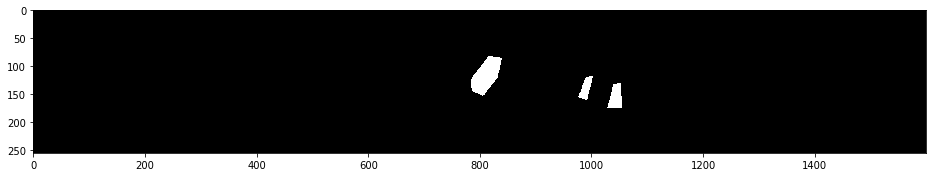

2188f5429 3 TEST 298834


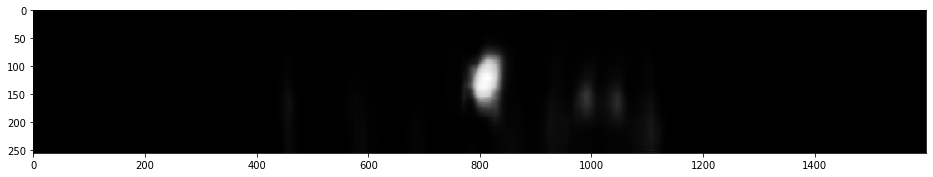

2188f5429 4 REF


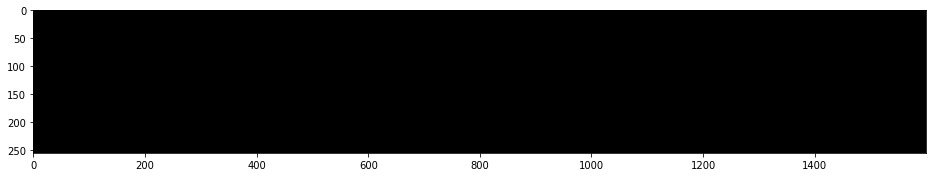

2188f5429 4 TEST 286149


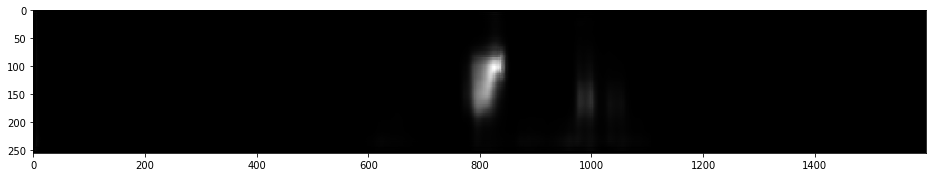

1a8440db2


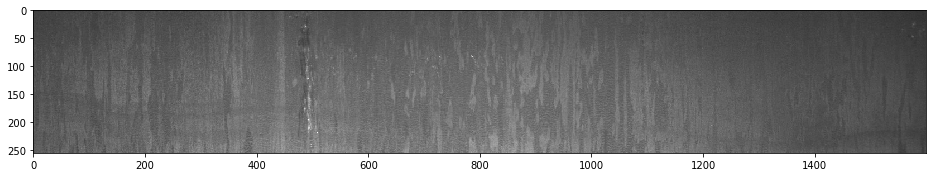

1a8440db2 1 REF


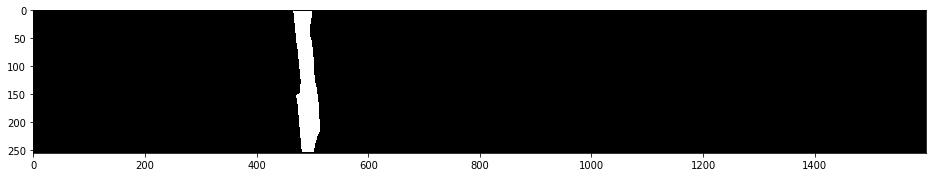

1a8440db2 1 TEST 406591


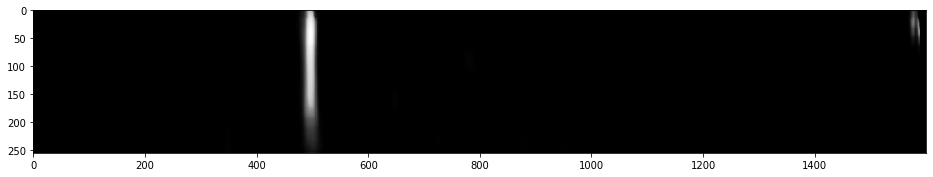

1a8440db2 2 REF


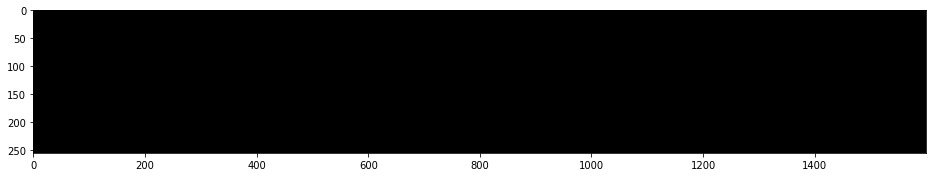

1a8440db2 2 TEST 379784


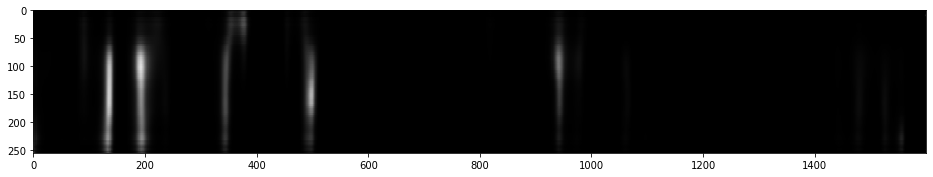

1a8440db2 3 REF


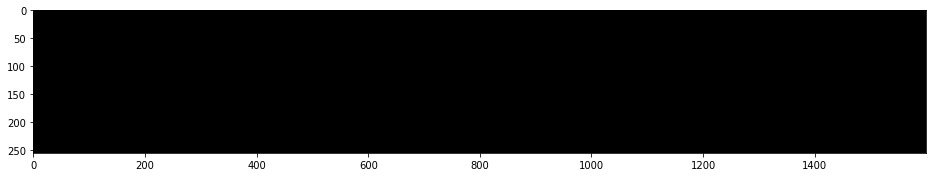

1a8440db2 3 TEST 409600


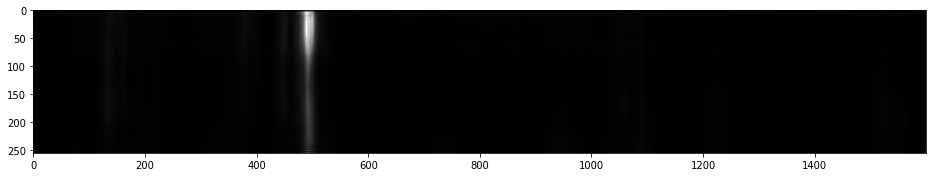

1a8440db2 4 REF


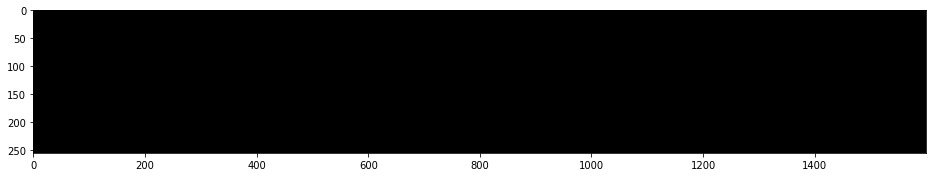

1a8440db2 4 TEST 409023


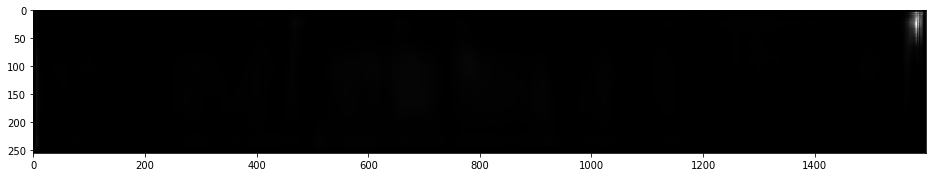

0e62d06d5


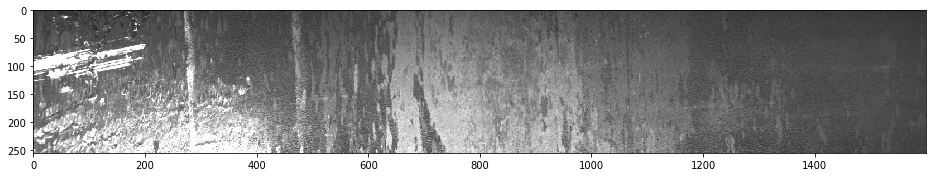

0e62d06d5 1 REF


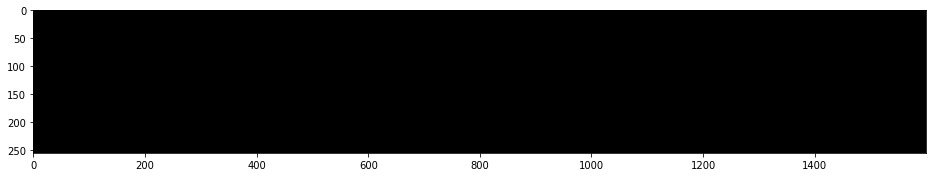

0e62d06d5 1 TEST 347876


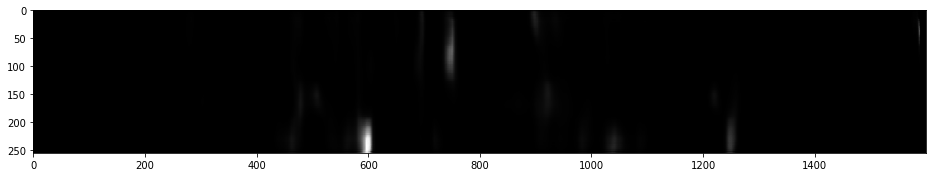

0e62d06d5 2 REF


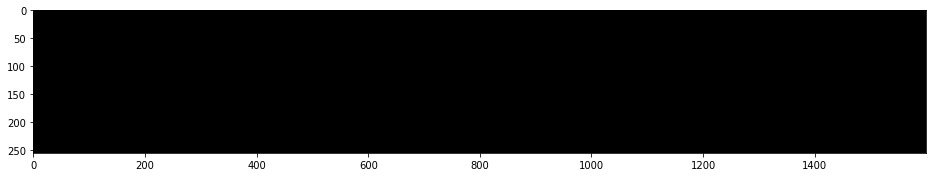

0e62d06d5 2 TEST 256786


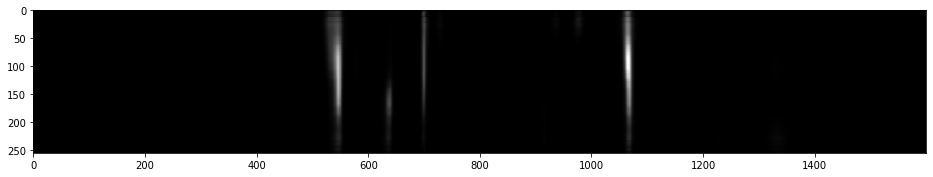

0e62d06d5 3 REF


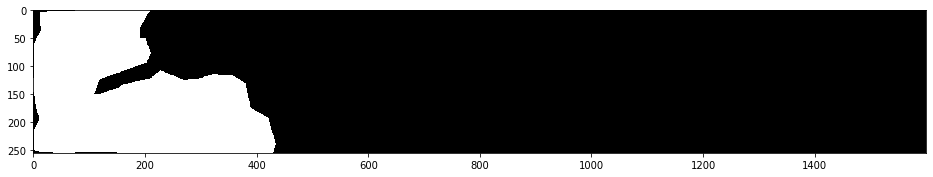

0e62d06d5 3 TEST 409600


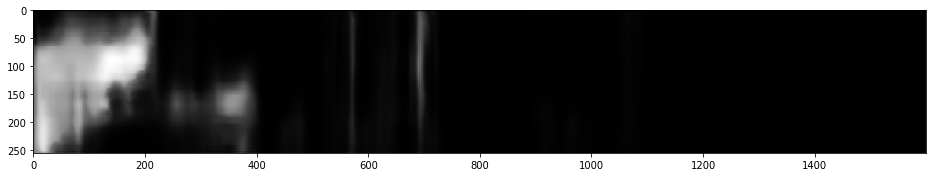

0e62d06d5 4 REF


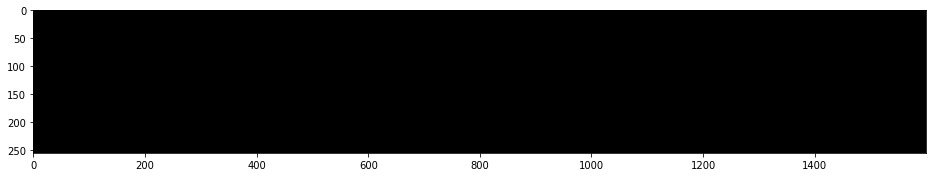

0e62d06d5 4 TEST 409089


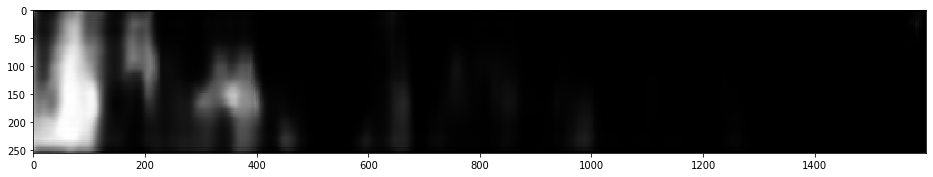

03461f8e0


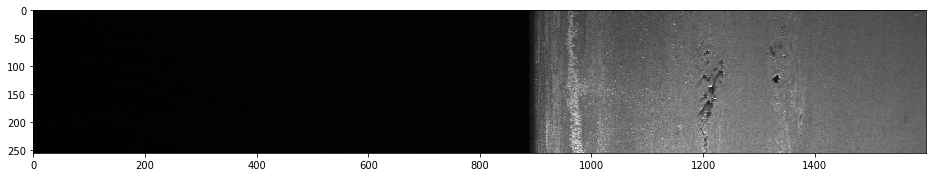

03461f8e0 1 REF


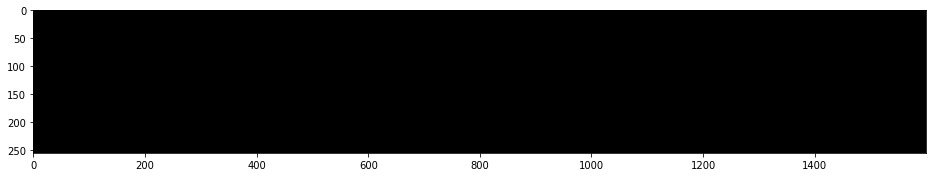

03461f8e0 1 TEST 172790


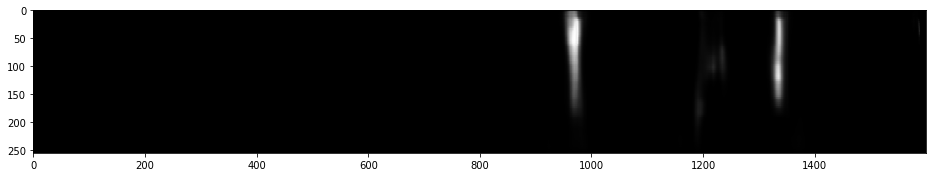

03461f8e0 2 REF


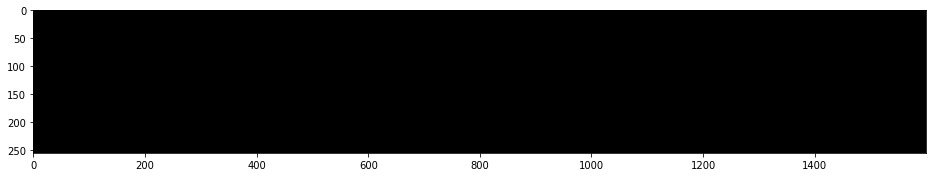

03461f8e0 2 TEST 78607


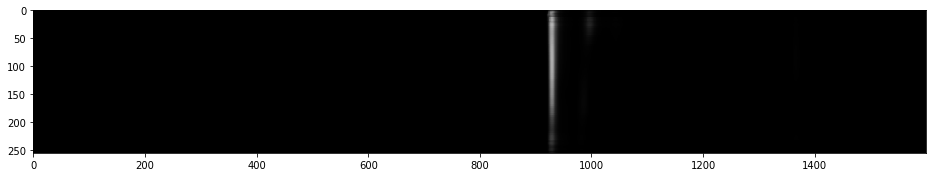

03461f8e0 3 REF


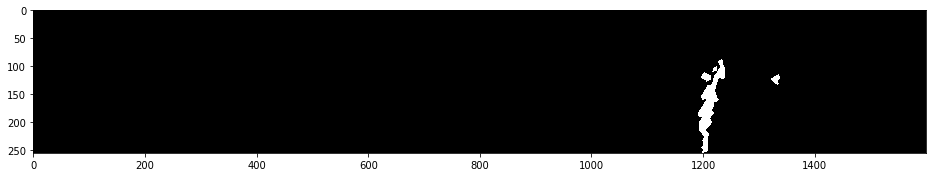

03461f8e0 3 TEST 186069


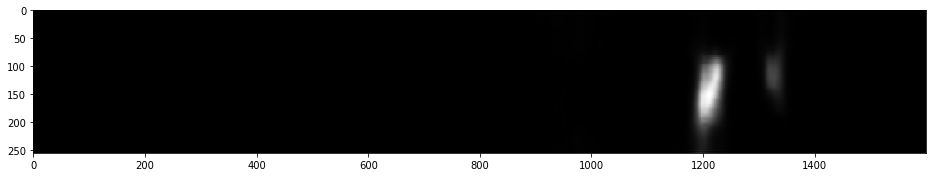

03461f8e0 4 REF


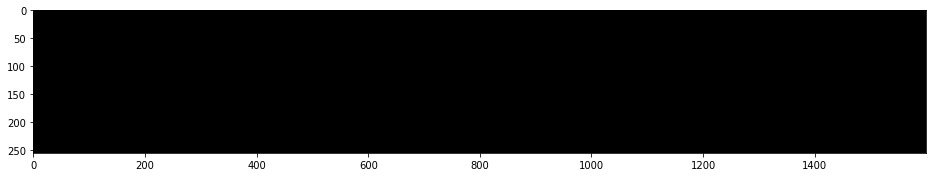

03461f8e0 4 TEST 179095


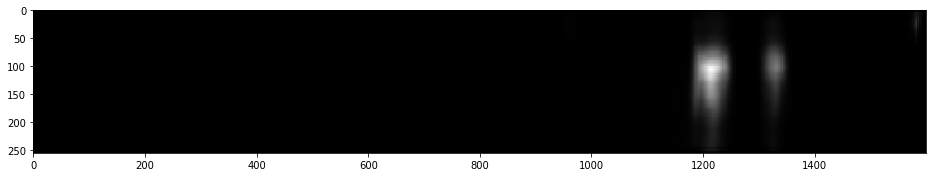

0ea00bf92


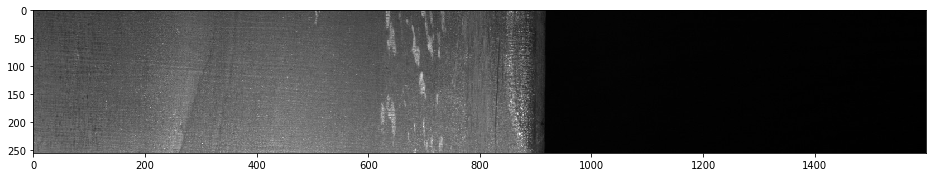

0ea00bf92 1 REF


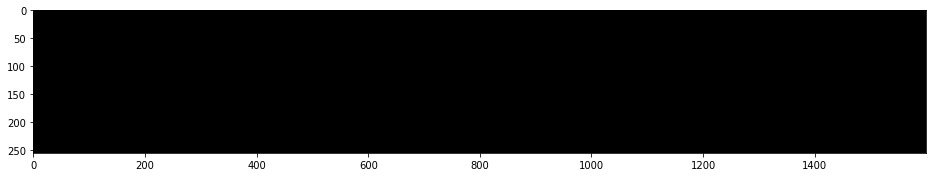

0ea00bf92 1 TEST 230441


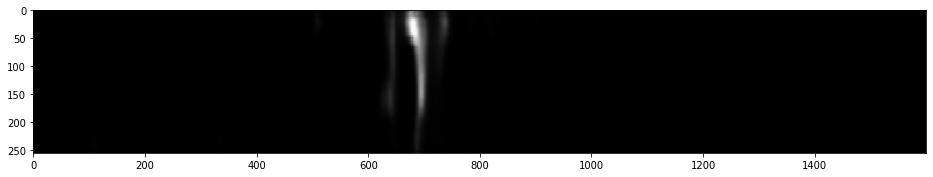

0ea00bf92 2 REF


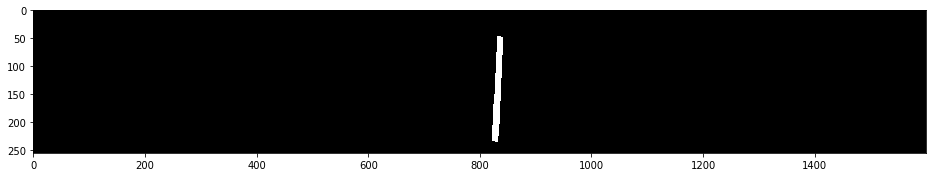

0ea00bf92 2 TEST 170614


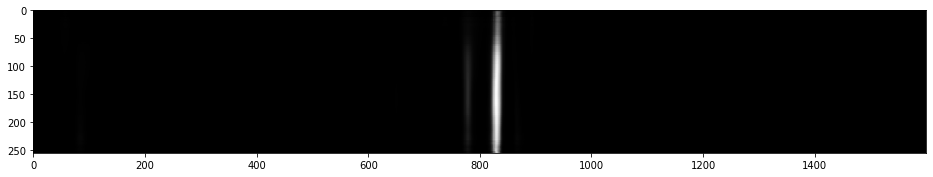

0ea00bf92 3 REF


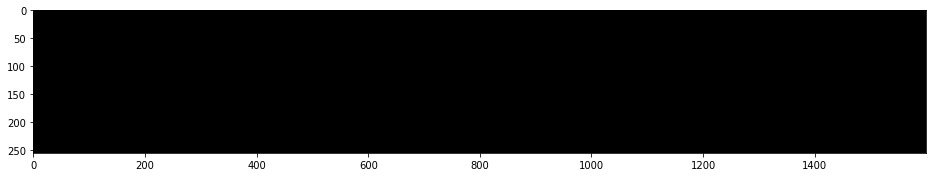

0ea00bf92 3 TEST 239844


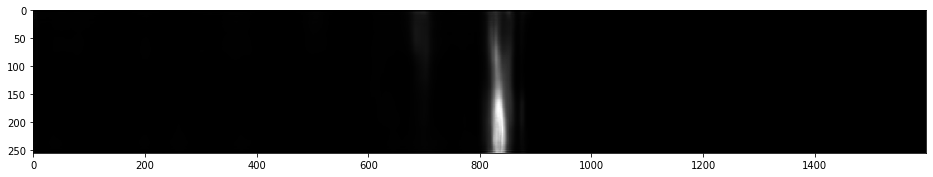

0ea00bf92 4 REF


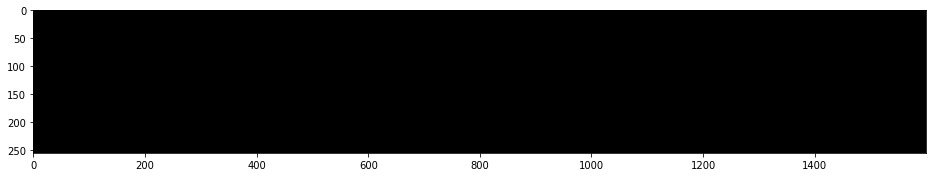

0ea00bf92 4 TEST 224455


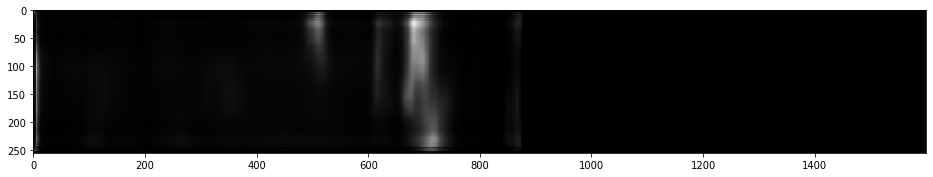

1849f8952


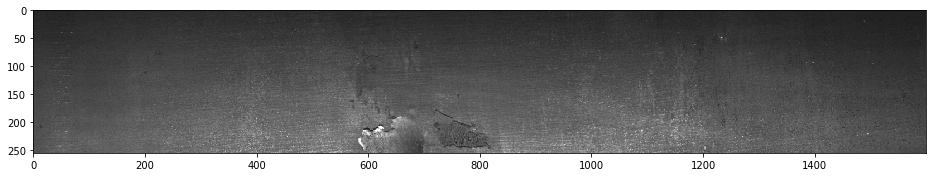

1849f8952 1 REF


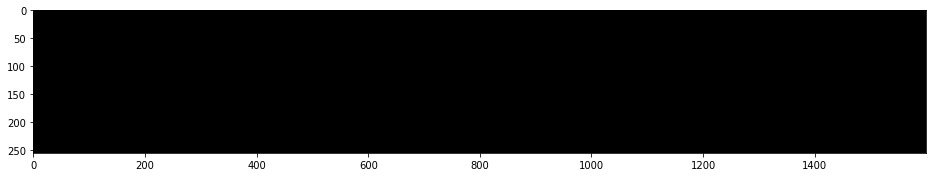

1849f8952 1 TEST 397103


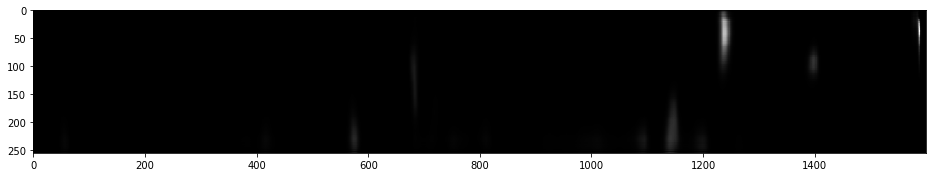

1849f8952 2 REF


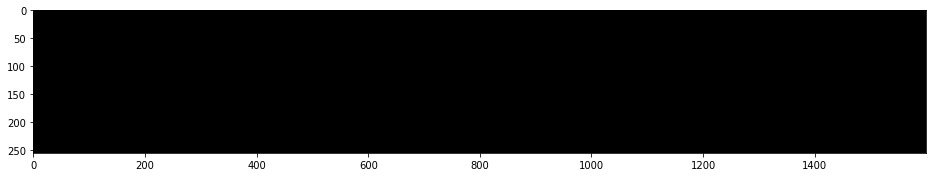

1849f8952 2 TEST 267116


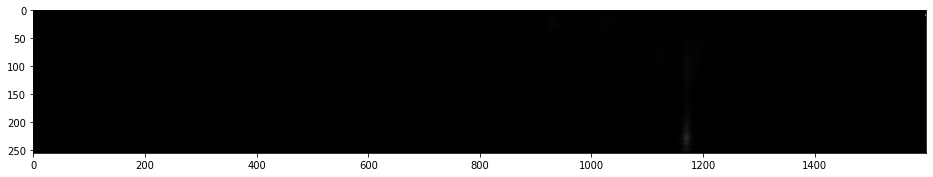

1849f8952 3 REF


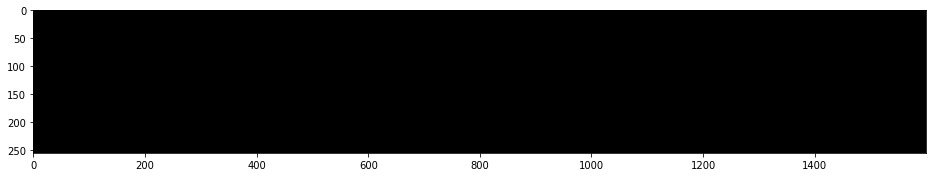

1849f8952 3 TEST 409600


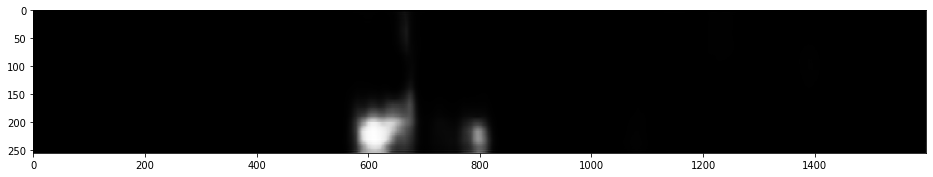

1849f8952 4 REF


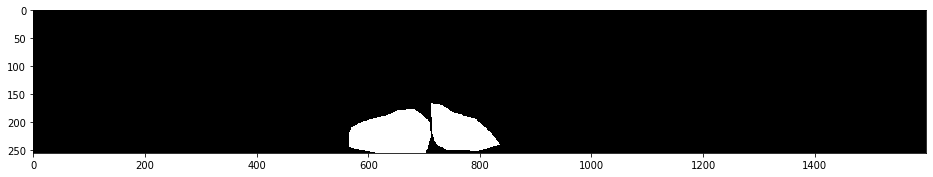

1849f8952 4 TEST 409472


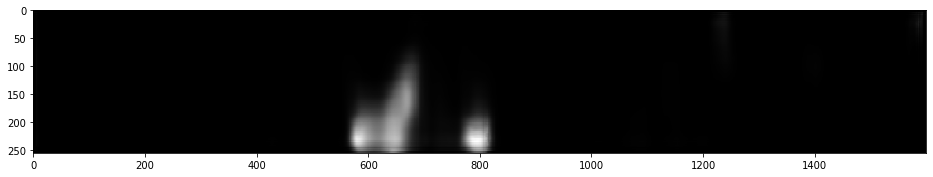

In [216]:
for i, name in enumerate(names):
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')
    im /= 255
    
    print(name)
    plt.figure(figsize=(16, 3))
    plt.imshow(im, cmap='gray')
    plt.show()
    
    for j in [1, 2, 3, 4]:
        rows = data[(data.imageid == name) & (data.classid == j)]
        row = rows.iloc[0, :]

        if row.mask_present:
            mask_ref = image_masks[f'{name}_{j}']
        else:
            mask_ref = np.zeros((HEIGHT, WIDTH), dtype='uint8')
            
        print(name, j, 'REF')
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_ref, cmap='gray')
        plt.show()
        
        mask_test = results[j - 1][i].squeeze()
        #mask_test = (mask_test > 0.5).astype('uint8')
        
        
        print(name, j, 'TEST', np.sum(mask_ref != mask_test))
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_test, cmap='gray')
        plt.show()
